# Pneumonia detection from chest x-ray images with transfer learning
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---

### What is this Notebook about?
In this notebook, we show a standard flow of transfer learning for image classification tasks by constructing a new model by,

- loading pre-trained weights of Inception V3 model (trained on the ImageNet database),
- freezing convolutional and associated layers, and
- adding a fresh global average pooling + dense layers on top.

Then, we train this new model with the X-ray Pneumonia dataset.

## The chest xray image dataset

The dataset can be found here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

According to the World Health Organization (WHO), pneumonia kills about 2 million children under 5 years old every year and is consistently estimated as the single leading cause of childhood mortality , killing more children than HIV/AIDS, malaria, and measles combined.

The WHO reports that nearly all cases (95%) of new-onset childhood clinical pneumonia occur in developing countries, particularly in Southeast Asia and Africa. Bacterial and viral pathogens are the two leading causes of pneumonia but require very different forms of management. Bacterial pneumonia requires urgent referral for immediate antibiotic treatment, while viral pneumonia is treated with supportive care. Therefore, accurate and timely diagnosis is imperative.

One key element of diagnosis is radiographic data, since chest X-rays are routinely obtained as standard of care and can help differentiate between different types of pneumonia. However, rapid radiologic interpretation of images is not always available, particularly in the low-resource settings where childhood pneumonia has the highest incidence and highest rates of mortality. To this end, it is beneficial to investigate the effectiveness of a transfer-learning-based image classification framework in classifying pediatric chest X-rays to detect pneumonia.

Read more about such deep learning based medical diagnosis applications in this paper: **[Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)**

---

In [ ]:
!pip install kagglehub

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import img_to_array, load_img
import cv2

In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"psr0049","key":"717c8536a5abaf9d97d6be717c0f10b1"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### How many examples are there?

In [12]:
train_directory = "/content/chest_xray/train/"
val_directory = "/content/chest_xray/val/"
test_directory = "/content/chest_xray/test/"

In [13]:
print('NORMAL training images:', len(os.listdir(train_directory+'/NORMAL/')))
print('PNEUMONIA training images:', len(os.listdir(train_directory+'/PNEUMONIA/')))
print('NORMAL validation images:', len(os.listdir(val_directory+'/NORMAL/')))
print('PNEUMONIA validation images:', len(os.listdir(val_directory+'/PNEUMONIA/')))
print('NORMAL test images:', len(os.listdir(test_directory+'/NORMAL/')))
print('PNEUMONIA test images:', len(os.listdir(test_directory+'/PNEUMONIA/')))

NORMAL training images: 1341
PNEUMONIA training images: 3875
NORMAL validation images: 8
PNEUMONIA validation images: 8
NORMAL test images: 234
PNEUMONIA test images: 390


### Can you tell the difference between the normal and pathological examples?

In [14]:
test_normal_names = os.listdir(test_directory+'/NORMAL/')
test_pneumonia_names = os.listdir(test_directory+'/PNEUMONIA/')

In [15]:
num_test_normal = len(test_normal_names)
num_test_pneumonia = len(test_pneumonia_names)

Here are 4 normal xray images...



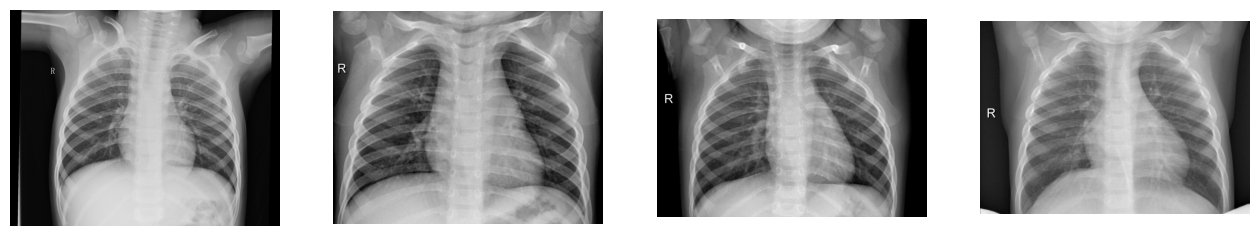

In [16]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
ax = ax.ravel()
print("Here are 4 normal xray images...\n")
for i in range(4):
    img_path = test_directory+'/NORMAL/'+test_normal_names[i]
    img = mpimg.imread(img_path)
    ax[i].imshow(img,cmap='gray')
    ax[i].axis('off')
plt.show()

Here are 4 pathological (pneumonia) xray images...



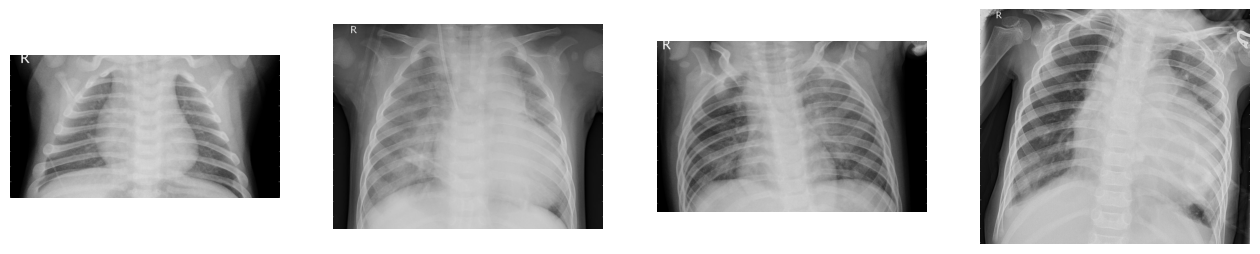

In [17]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
ax = ax.ravel()
print("Here are 4 pathological (pneumonia) xray images...\n")
for i in range(4):
    img_path = test_directory+'/PNEUMONIA/'+test_pneumonia_names[i]
    img = mpimg.imread(img_path)
    ax[i].imshow(img,cmap='gray')
    ax[i].axis('off')
plt.show()

In [18]:
def predict_class(ndarray):
    """
    Predicts the class from the output array of a neural net output
    """
    return np.argmax(ndarray)

## Transfer learning with Inception-V3 model

Inception V3 was the 1st Runner Up for image classification in ILSVRC ([ImageNet Large Scale Visual Recognition Competition](http://www.image-net.org/challenges/LSVRC/)) 2015.

The Inception deep convolutional architecture was introduced as GoogLeNet in ([Szegedy et al. 2015a](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf)), here named Inception-V1. Later the Inception architecture was refined in various ways, first by the introduction of batch normalization ([Ioffe and Szegedy 2015](http://proceedings.mlr.press/v37/ioffe15.pdf)) (Inception-V2). Later by additional factorization ideas in the third iteration ([Szegedy et al. 2015b](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf)) which will be referred to as Inception-V3.

Read this article to know more about this model.

https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c

In [19]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import RMSprop,Adam

### Create the base pre-trained model

In [20]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Add a global spatial average pooling layer

In [21]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

### Add a couple of densely connected layers

In [22]:
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)

### Add a logistic layer for binary calssification (we can still use a softmax)

In [23]:
predictions = Dense(2, activation='softmax')(x)

### This is the final model

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

### Train only the top layers and freeze all convolutional InceptionV3 layers

In [25]:
for layer in base_model.layers:
    layer.trainable = False

### Compile

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['acc'])

### Summary (it's a long one)

- Total params: 22,917,794
- Trainable params: 1,115,010
- Non-trainable params: 21,802,784

So, only 1.1 million parameters (weights) will be trained out of 22.9 million total weights in this model. Rest come from the Inception V3 model.

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 22,917,794 (87.42 MB)

 Trainable params: 1,115,010 (4.25 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Create an `ImageDataGenerator` object to scale and use the `flow_from_directory` method to yield training images one by one

We create both `train_generator` and `val_generator` objects to train and check validation accuracy while training.

Note, however, that because we have only a modest amount of validation images, we set the `batch_size=1` for `val_generator`

In [28]:
batch_size=64

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

In [30]:
# Flow training images in batches using the generator
train_generator = train_datagen.flow_from_directory(train_directory,target_size=(200,200),batch_size=batch_size)
val_generator = val_datagen.flow_from_directory(val_directory,target_size=(200,200),batch_size=1)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [31]:
train_sample = train_generator.n
val_sample = val_generator.n

### Use the `fit_generator` method to utilize the `train_generator` object

Remember to pass on both train and val generators to the fit function.

Note the `steps_per_epoch` argument to `fit_generator`. Since, this is a generic [Python generator](https://realpython.com/introduction-to-python-generators/), it never stops and therefore will not know where a particular epoch is ending and the next one is starting. **We have to let it know the steps in a single epoch**. This is, in most cases, the length of the total training sample divided by the batch size.

For `validation_steps` we just pass on the `val_sample` since batch size is 1 for validation set.

In [32]:
model.fit(train_generator,
                    steps_per_epoch=int(train_sample/batch_size)+1,
                    validation_data=val_generator,
                    validation_steps=val_sample,
                    epochs=20)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 747ms/step - acc: 0.7438 - loss: 1.1703 - val_acc: 0.8125 - val_loss: 0.2605
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 57s 580ms/step - acc: 0.9476 - loss: 0.1358 - val_acc: 0.9375 - val_loss: 0.1990
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - acc: 0.9515 - loss: 0.1260 - val_acc: 0.8750 - val_loss: 0.1543
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 584ms/step - acc: 0.9517 - loss: 0.1177 - val_acc: 0.9375 - val_loss: 0.2131
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 578ms/step - acc: 0.9729 - loss: 0.0803 - val_acc: 0.7500 - val_loss: 0.5302
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 580ms/step - acc: 0.9751 - loss: 0.0701 - val_acc: 0.8125 - val_loss: 0.4010
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 571ms/step - acc: 0.9699 - loss: 0.0828 - val_acc: 0.8750 - val_loss: 0.4437
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - acc: 0.9603 - loss: 0.1044 - val_acc: 0.6875 - val_loss: 0.6952
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 573ms/

### Plot training and validation accuracy over epochs

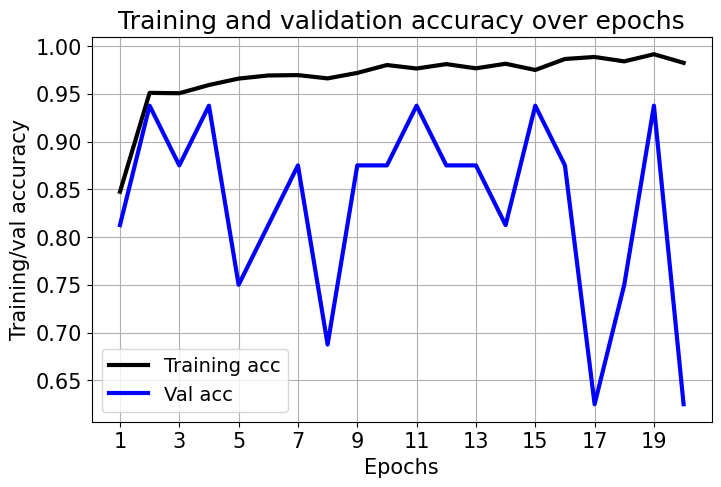

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Training and validation accuracy over epochs",fontsize=18)
plt.plot(np.arange(1,21),model.history.history['acc'],c='k',lw=3)
plt.plot(np.arange(1,21),model.history.history['val_acc'],c='blue',lw=3)
plt.legend(['Training acc','Val acc'],fontsize=14)
plt.grid(True)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Training/val accuracy",fontsize=15)
plt.xticks(np.arange(1,21,2),fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Check the accuracy on the test images

In [34]:
normal_array=[]
for i in range(num_test_normal):
    img_path = test_directory+'/NORMAL/'+test_normal_names[i]
    img = load_img(img_path)
    img = img_to_array(img)
    img = img/255.0
    img = cv2.resize(img,(200,200))
    img = np.expand_dims(img,axis=0)
    normal_array.append(predict_class(model.predict(img)))

normal_array = np.array(normal_array)
normal_correct = (normal_array==0).sum()

print("Out of {} normal images the model predicted correctly for {} images".format(num_test_normal,normal_correct))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━

In [35]:
pneumonia_array=[]
for i in range(num_test_pneumonia):
    img_path = test_directory+'/PNEUMONIA/'+test_pneumonia_names[i]
    img = load_img(img_path)
    img = img_to_array(img)
    img = img/255.0
    img = cv2.resize(img,(200,200))
    img = np.expand_dims(img,axis=0)
    pneumonia_array.append(np.argmax(model.predict(img),axis=1))

pneumonia_array = np.array(pneumonia_array)
pneumonia_correct = (pneumonia_array==1).sum()

print("Out of {} pneumonia images the model predicted correctly for {} images".format(num_test_pneumonia,pneumonia_correct))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

## Summary
We created a transfer-learning model based on the famous Inception V3 and trained it with chest X-ray images for pneumonia detection. While the classifier makes good prediction for true pneumonia images, its prediction is underwhelming for the normal cases i.e. it makes a lot of false positive errors (classifies the image as pneumonia when it is not).

Further hyperparameter tuning may be needed for getting a good overall performance. Also, we resized the images to 200x200 from a high-quality, and that may be impacting some of the performance.

The validation error plot looks erratic, and therefore, we may simply have to reduce the learning rate and train for far larger number of epochs.

However, the notebook provides a step-by-step illustration of transfer learning with a pre-trained model.